# EDA Project 2 - 
_______

### Background
These data provide a window into how people are interacting with the government online. The data come from a unified Google Analytics account for U.S. federal government agencies known as the Digital Analytics Program. This program helps government agencies understand how people find, access, and use government services online. The program does not track individuals, and anonymizes the IP addresses of visitors.

Not every government website is represented in these data. Currently, the Digital Analytics Program collects web traffic from around 400 executive branch government domains, across about 5,700 total websites, including every cabinet department.

One of the challenges of this project was acquiring data.  The original dataset we prospected was found to be corrupted.
After looking at the data, we found that the data contained so many errors, it would have been nearly impossible to complete the project as planned.

The data was corrupted by human error.  The developers who maintain the dataset, allowed synthetic data to contaminate the downloadable `.csv` files they make available to the public.  Over half of the observations contained website domains such as www.fakesite.com.  

 


### Data Collection

Instead of waiting for the data errors to be fixed and run the risk of having incomplete data for our project, we decided to proceed with acquiring data through the API.  We did need to adjust our initial data questions as the API is still in BETA and did not have the same headers available as the `.csv` files.  Where we did lose some variable information, we did gain the ability to acquire time-series data, which was not available in the original dataset. 

#### Reports

The analytics.usa.gov has made the following datasets available for download:
- Download: Refers to the number of times a file or asset has been downloaded from a website.
- Traffic-source: Refers to the channel or medium that a visitor used to reach a website, such as organic search, social media, or paid advertising.
- Device-model: Refers to the specific model of device that a visitor used to access a website, such as an iPhone X or Samsung Galaxy S21.
- Domain: Refers to the main domain name of a website, such as example.com.
- Site: Refers to a specific subdomain or section of a website, such as blog.example.com.
- Second-level-domain: Refers to the part of a domain name that comes before the top-level domain (TLD), such as example in example.com.
- Language: Refers to the primary language of a website or the language preference of a visitor's browser.
- OS-browser: Refers to the combination of operating system and web browser used by a visitor to access a website, such as Windows 10 and Chrome.
- Windows-browser: Refers specifically to web browsers running on the Windows operating system, such as Internet Explorer or Microsoft Edge.
- Browser: Refers to the specific web browser used by a visitor to access a website, such as Chrome, Firefox, or Safari.
- Windows-ie: Refers specifically to the Internet Explorer web browser running on the Windows operating system.
- OS: Refers to the specific operating system used by a visitor to access a website, such as Windows, macOS, iOS, or Android.
- Windows: Refers specifically to the Windows operating system.
- IE: Refers specifically to the Internet Explorer web browser.

### Inclusion and Exclusion Assumptions for Report Selection

#### Included Reports 
How does this support our questions?

**Language_report_all_agencies.parquet** - Daily visits per language to each agency sites

**Site_report_all_agencies.parquet** - Is not clear what is the difference between this and the domain report.

**Traffic-source_report_all_agencies.parquet** - Daily visits to agencies sites broken down by source domain.

### Excluded Reports





#### Agencies and Time Selection Criteria
‘health-human-services', 
'postal-service', 
'social-security-administration',
'treasury'

## Workflow Goals

### Import Libraries

In [1]:
from collections.abc import Sequence
from IPython.display import display
import datetime
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns

from utils import api_to_parquet, remove_outliers
import pyarrow.parquet as pq
from tqdm import tqdm
pd.options.display.max_colwidth = 10000
%matplotlib inline

### API Call

(describe)

In [3]:
# list_of_agencies = [
#     'health-human-services', 
#     'postal-service', 
#     'social-security-administration',
#     'treasury',
#     ]
# list_of_reports = ['site', 'traffic-source', 'language']

# # api key 
# api_key = 'your_api_key_here'

# # call the function
# api_to_parquet(list_of_agencies, list_of_reports, api_key, response_limit=1000)


### Load Dataset
(observations & notes)

In [17]:
df_sites = pd.read_parquet('./data/site_report_all_agencies.parquet')
df_traffic_source = pd.read_parquet('./data/traffic-source_report_all_agencies.parquet')
df_language = pd.read_parquet('./data/language_report_all_agencies.parquet')

In [18]:
display(df_sites.info())
display(df_traffic_source.info())
display(df_language.info())

<class 'pandas.core.frame.DataFrame'>
Index: 667504 entries, 0 to 104
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             667504 non-null  int64         
 1   date           667504 non-null  datetime64[ns]
 2   report_name    667504 non-null  object        
 3   report_agency  667504 non-null  object        
 4   domain         667504 non-null  object        
 5   visits         667504 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 35.6+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 161296 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   id                   161296 non-null  int64         
 1   date                 161296 non-null  datetime64[ns]
 2   report_name          161296 non-null  object        
 3   report_agency        161296 non-null  object        
 4   source               161296 non-null  object        
 5   visits               161296 non-null  int64         
 6   has_social_referral  161296 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 9.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
Index: 978426 entries, 0 to 188
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   id             978426 non-null  int64         
 1   date           978426 non-null  datetime64[ns]
 2   report_name    978426 non-null  object        
 3   report_agency  978426 non-null  object        
 4   visits         978426 non-null  int64         
 5   language       978426 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 52.3+ MB


None

### Data Cleansing

- Check for na values

In [19]:
ct = pd.concat([df_sites.isna().sum(), df_language.isna().sum(), df_traffic_source.isna().sum()], axis=1, keys = ['Sites Report', 'Language Report', 'Traffic Source Report'])
ct

,Sites Report,Language Report,Traffic Source Report
id,0.0,0.0,0.0
date,0.0,0.0,0.0
report_name,0.0,0.0,0.0
report_agency,0.0,0.0,0.0
domain,0.0,NaN,NaN
visits,0.0,0.0,0.0
language,NaN,0.0,NaN
source,NaN,NaN,0.0
has_social_referral,NaN,NaN,0.0


#### Check for string formatting

In [20]:
pattern = r'^[\w\.\-\_]+$'

source_pattern = df_traffic_source['source'].str.contains(pattern)
nonalpha_source = df_traffic_source.loc[~source_pattern, 'source']
nonalpha_visits = df_traffic_source.loc[~source_pattern, 'visits']

df_nonalpha_traffic = pd.DataFrame({'source': nonalpha_source, 'visits': nonalpha_visits})

nonalpha_grouped = df_nonalpha_traffic.groupby('source').sum().sort_values('visits', ascending=False)
nonalpha_grouped


,visits
source,
(direct),479199136
PaidVideo;5782978,118976
atlnet2.bi.ssa.gov:8080,108985
PaidVideo;4190268,98310
Order Shipped Flow - Fulfilled Order,78874
...,...
TaxSpeaker Subscribers,125
UF at Work,120
EA - Order Shipped,117


In [21]:
df_language[['language', 'visits']].groupby('language').sum().sort_values('visits', ascending=False)


,visits
language,
en-us,80239693352
en,5674281147
en-gb,2443554924
es-419,1150487625
es-us,1101489480
...,...
pl-gb,103
fr-tg,102
ar-tn,101


#### Drop Unnecessary Columns

In [22]:
# Drop columns using .drop()
df_sites = df_sites.drop(columns=['id'])
df_traffic_source = df_traffic_source.drop(columns=['id'])
df_language = df_language.drop(columns=['id'])

#### Cleansing Summary

### Data Exploration

- [Alex] 1. How many sites and agencies do the reports contain information about?
    - Count unique combinations of agencies and sites
- [Austin] 2. Any missing or null values? Any other gaps in the data?
    - For each report and column, are there any NaN values
- [Austin] 3. Do aggregate visit values fall within expectations (eg. # visits as % of US population seems realistic)
   - Sanity of volume of visits. From the site report, for a given day calculate the number of visits per agency. Compare against each other and see the scale of the value
- [Philip] 4. Are there any unexpected values? (negative domain visits, anomaly: large day over day drops in visits)
    - We could choose a large domain and for a given month, show a table with d/d differences %s.
    - This might be a good moment to explain the weekly seasonality of visits observe in the data (weekends have lower # visits)
- [Alex] 5. Do we understand the meaning of all columns? For example “source”
   - Source: page where user is coming from (direct, search referral (google.com, , social referral facebook, ig, twitter)
- [Philip] Outliers: are there any domains with too high or too low # visits? 
   - 2-3 std diff
   - box-plots


- [Alex] 1. How many sites and agencies do the reports contain information about?
    - Count unique combinations of agencies and sites

- [Austin] 2. Any missing or null values? Any other gaps in the data?
    - For each report and column, are there any NaN values

- [Austin] 3. Do aggregate visit values fall within expectations (eg. # visits as % of US population seems realistic)
   - Sanity of volume of visits. From the site report, for a given day calculate the number of visits per agency. Compare against each other and see the scale of the value

#### Outliers

- [Philip] 4. Are there any unexpected values? (negative domain visits, anomaly: large day over day drops in visits)
    - We could choose a large domain and for a given month, show a table with d/d differences %s.

In [23]:
# Index of the top 5 domains by visits.
top_domains = df_sites.groupby('domain')['visits'].sum().nlargest(5).index

# Convert the date column to a daily periodicity.
df_sites['day'] = df_sites['date'].dt.to_period('D')

# Get daily data for the top domains grouped by domain and date.
daily_data = df_sites[df_sites['domain'].isin(top_domains)].groupby(['domain', 'day'])['visits'].sum().reset_index()

# Calculate the day-over-day percentage change in visits for each domain.
daily_data['pct_change'] = daily_data.groupby('domain')['visits'].pct_change()

# Filter the data to keep only the largest > 50% drops.
large_drops = daily_data[daily_data['pct_change'] < -0.5]


In [24]:
# Sort the data by the largest percentage in drops.
large_drops.sort_values('pct_change', ascending=True)

,domain,day,visits,pct_change
4329,sa.www4.irs.gov,2021-12-24,783,-0.997145
3855,sa.www4.irs.gov,2020-09-06,11994,-0.987348
4352,sa.www4.irs.gov,2022-06-29,50634,-0.982932
3708,sa.www4.irs.gov,2020-04-12,96423,-0.975932
3963,sa.www4.irs.gov,2020-12-23,249342,-0.953808
...,...,...,...,...
305,informeddelivery.usps.com,2020-11-01,1593033,-0.500943
746,informeddelivery.usps.com,2022-01-16,2629959,-0.500748
270,informeddelivery.usps.com,2020-09-27,1700936,-0.500495
2653,reg.usps.com,2020-09-06,2333787,-0.500325


/tmp/ipykernel_5016/3909943234.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_major_formatter(plt.FixedFormatter(large_drops['day'].astype(str).unique()))


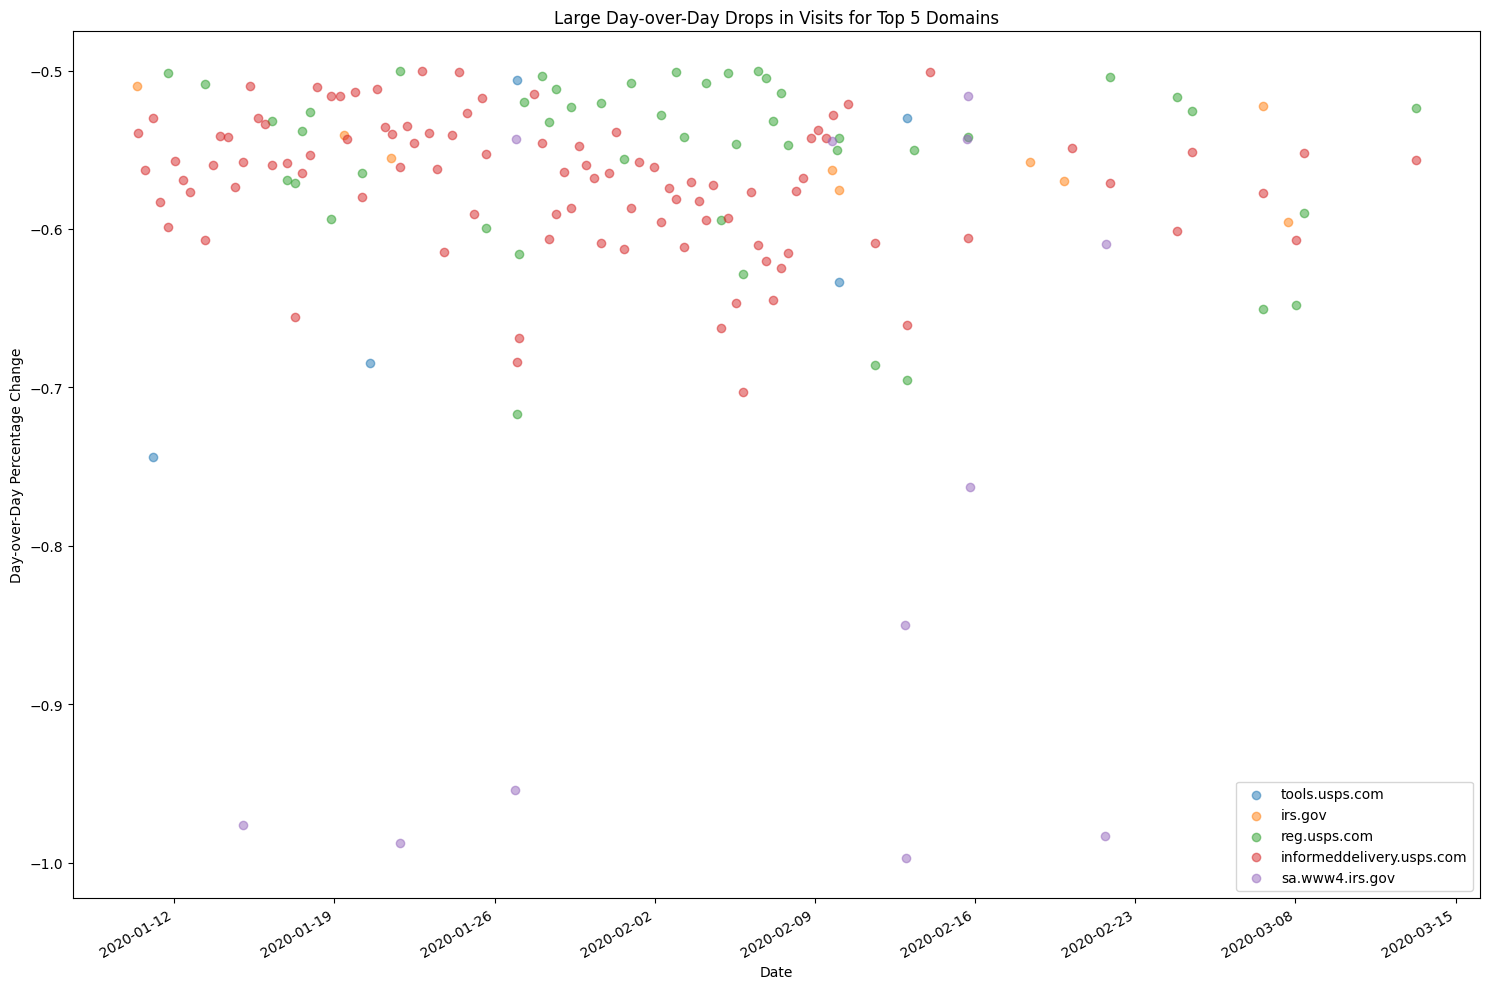

In [27]:
# Create a scatter plot to visualize large
fig, ax = plt.subplots(figsize=(15, 10))
for domain in top_domains:
    domain_data = large_drops[large_drops['domain'] == domain]
    ax.scatter(x=domain_data['day'].dt.to_timestamp(), y=domain_data['pct_change'], alpha=0.5, label=domain)

# Format the x-axis to display dates
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(plt.FixedFormatter(large_drops['day'].astype(str).unique()))

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Day-over-Day Percentage Change')
ax.set_title('Large Day-over-Day Drops in Visits for Top 5 Domains')

# Rotate x-axis labels
plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# Add a legend with tight layout and show the plot
plt.legend()
plt.tight_layout()
plt.show()

This might be a good moment to explain the weekly seasonality of visits observe in the data (weekends have lower # visits)

In [26]:
# Set the start and end dates for the data to zoom
start_date = '2021-01-01'
end_date = '2021-12-31'

# Group by agency and domain
top_domains_by_agency = df_sites.groupby(['report_agency', 'domain'])['visits'].sum().reset_index()

# Get the top 5 domains for each agency
top_domains_by_agency = top_domains_by_agency.groupby('report_agency').apply(lambda x: x.nlargest(5, 'visits')).reset_index(drop=True)

# Set the date column to a monthly periodicity.
df_sites['month'] = df_sites['date'].dt.to_period('M')

# Monthly visits for each domain with start and end dates grouped by agency, domain and month.
monthly_data = df_sites[(df_sites['domain'] \
                         .isin(top_domains_by_agency['domain'])) & (df_sites['date'] >= start_date) & (df_sites['date'] <= end_date)] \
                         .groupby(['report_agency', 'domain', 'month'])['visits'].sum().reset_index()

# Show the top 5 domains for each agency
report_agencies = df_sites['report_agency'].unique()


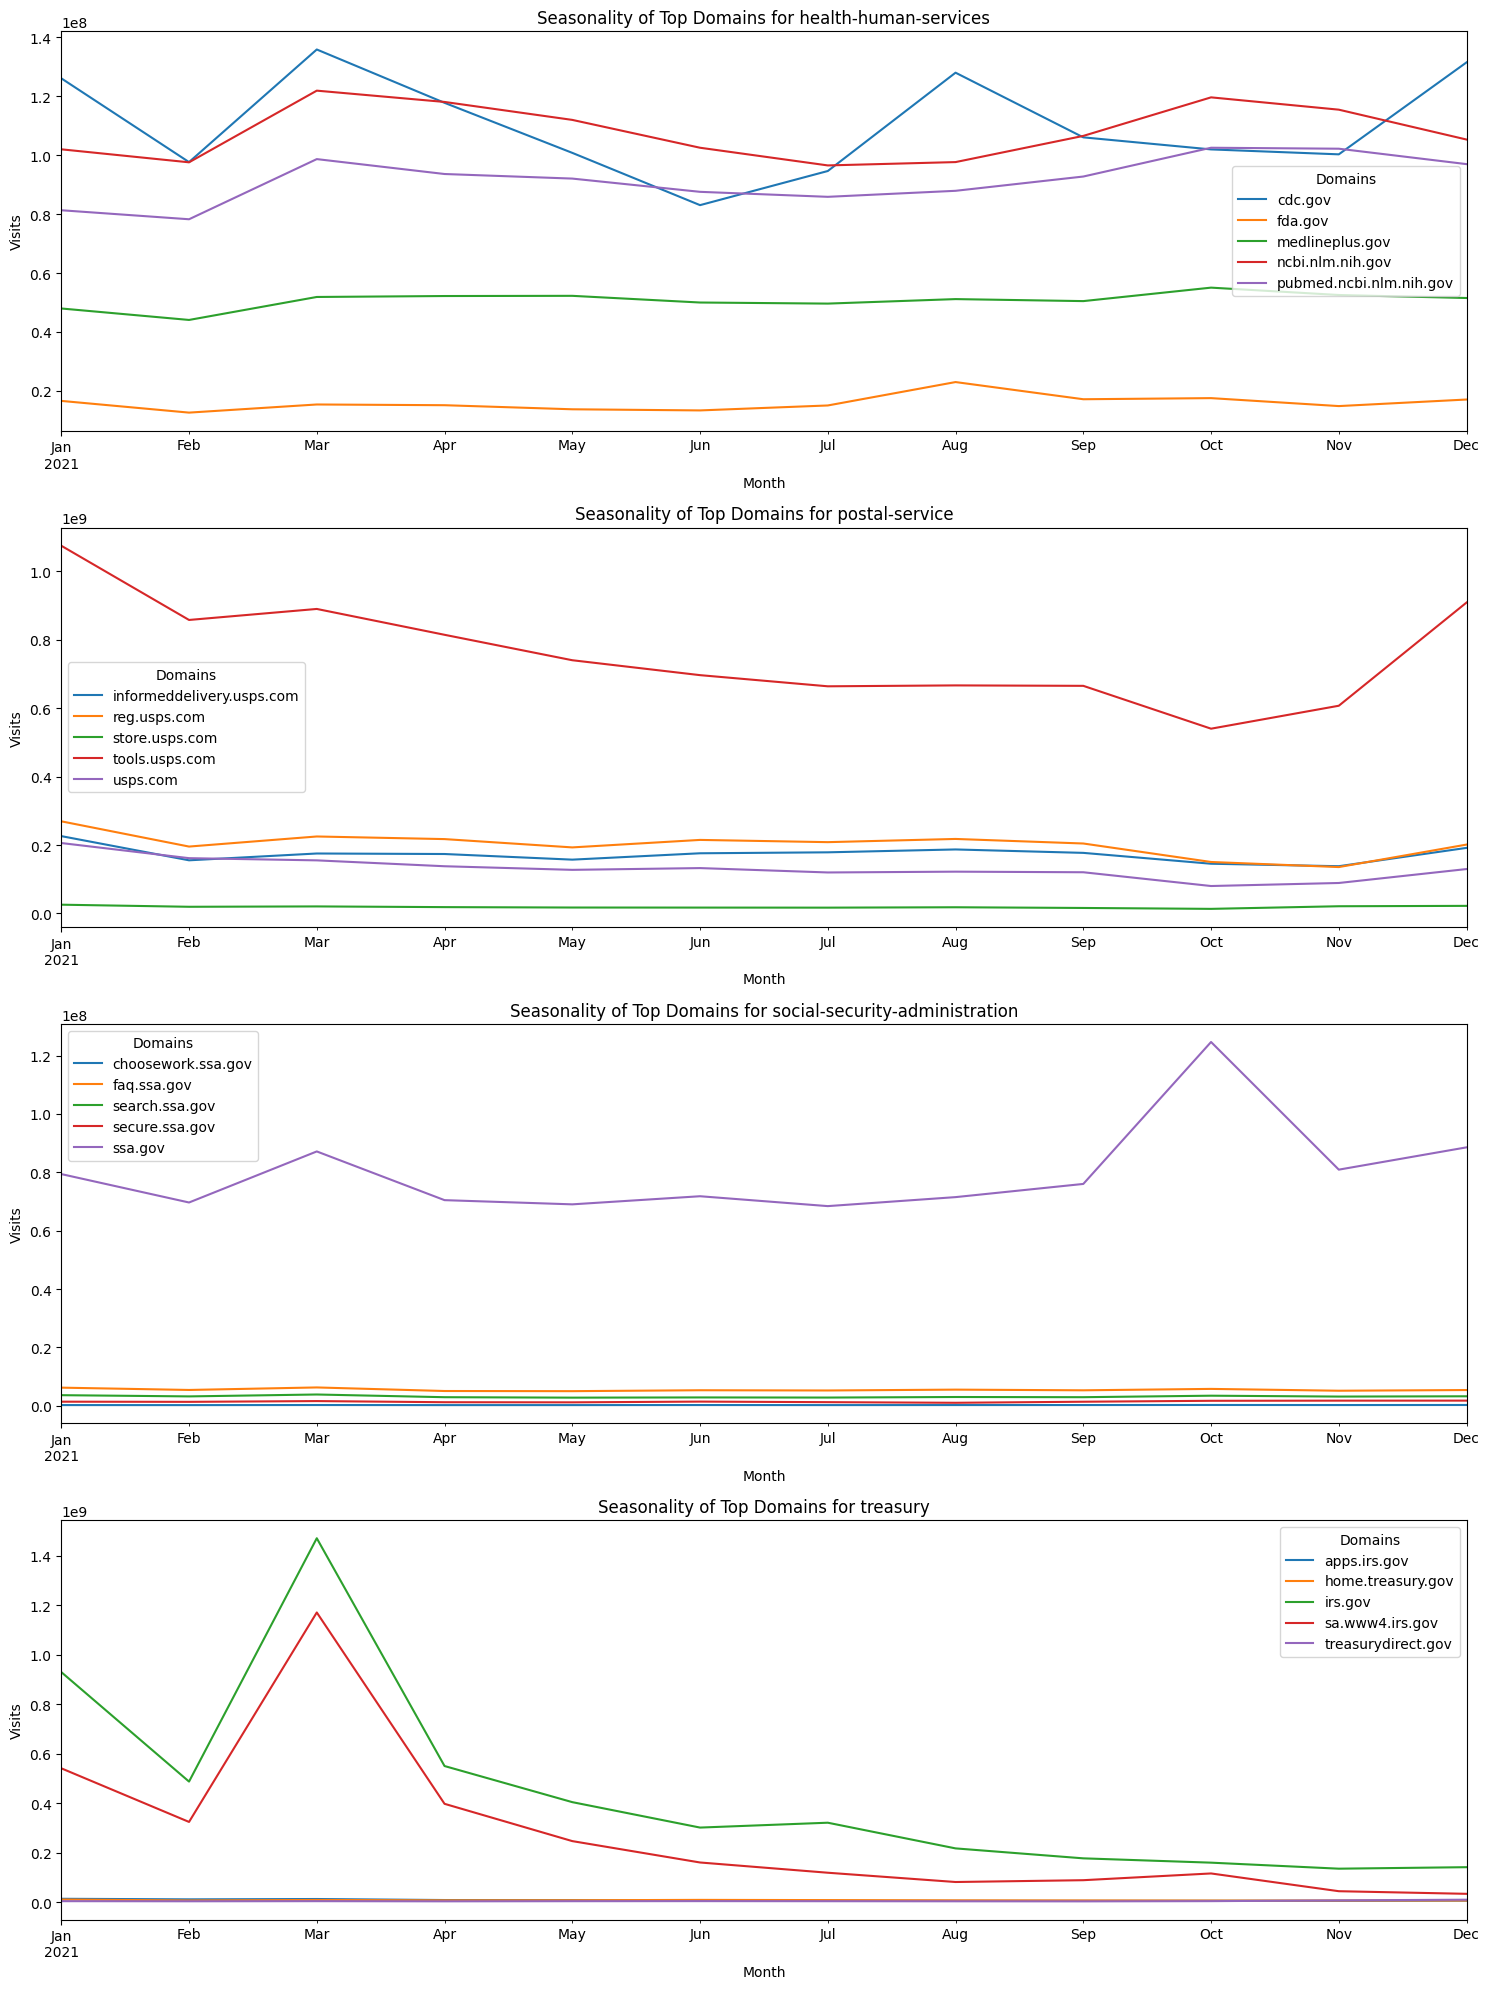

In [28]:
# Create a figure with a subplot for each agency
fig, axes = plt.subplots(nrows=len(report_agencies), figsize=(15, 5 * len(report_agencies)))

# Loop through each agency and plot the monthly visits for each domain
for i, agency in enumerate(report_agencies):
    agency_data = monthly_data[monthly_data['report_agency'] == agency].pivot_table(values='visits', index='month', columns='domain', aggfunc='sum')
    agency_data.plot(ax=axes[i], title=f"Seasonality of Top Domains for {agency}", xlabel="Month", ylabel="Visits")
    axes[i].legend(title='Domains')

# Add a tight layout and show the plot
plt.tight_layout()
plt.show()

- [Alex] 5. Do we understand the meaning of all columns? For example “source”
   - Source: page where user is coming from (direct, search referral (google.com, , social referral facebook, ig, twitter)

- [Philip] Outliers: are there any domains with too high or too low # visits? 
   - 2-3 std diff
   - box-plots

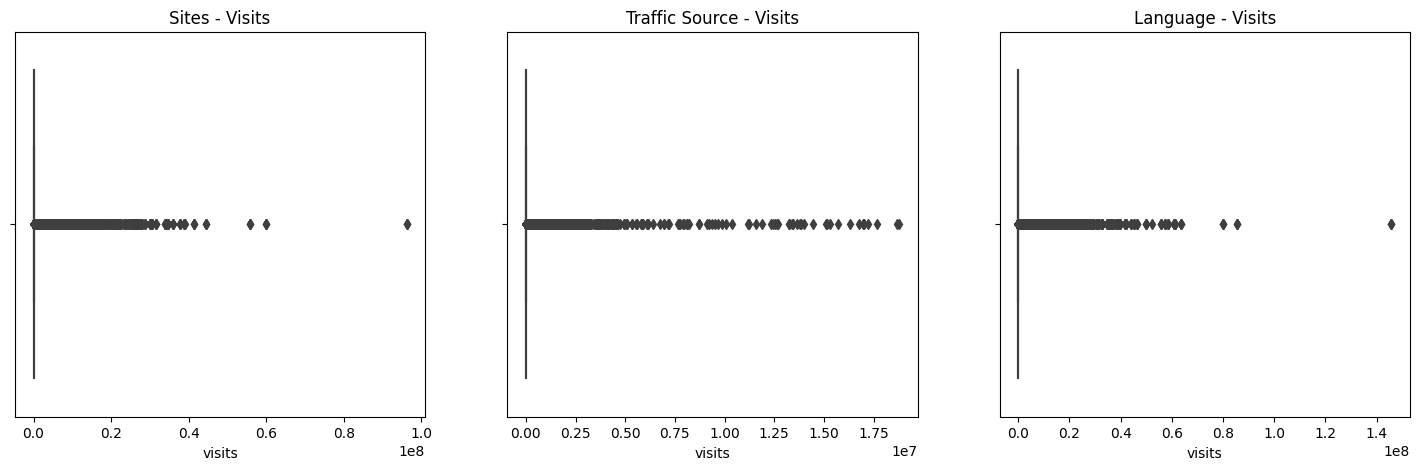

In [29]:

plt.figure(figsize=(18, 5))

# Create a boxplot for each report
plt.subplot(1, 3, 1)
sns.boxplot(data=df_sites, x='visits')
plt.title('Sites - Visits')

plt.subplot(1, 3, 2)
sns.boxplot(data=df_traffic_source, x='visits')
plt.title('Traffic Source - Visits')

plt.subplot(1, 3, 3)
sns.boxplot(data=df_language, x='visits')
plt.title('Language - Visits')

plt.show()

In [30]:
# Remove visit outliers with the interquartile range of the middle 50%.
sites_no_outliers = remove_outliers(df_sites['visits'])
traffic_source_no_outliers = remove_outliers(df_traffic_source['visits'])
language_no_outliers = remove_outliers(df_language['visits'])

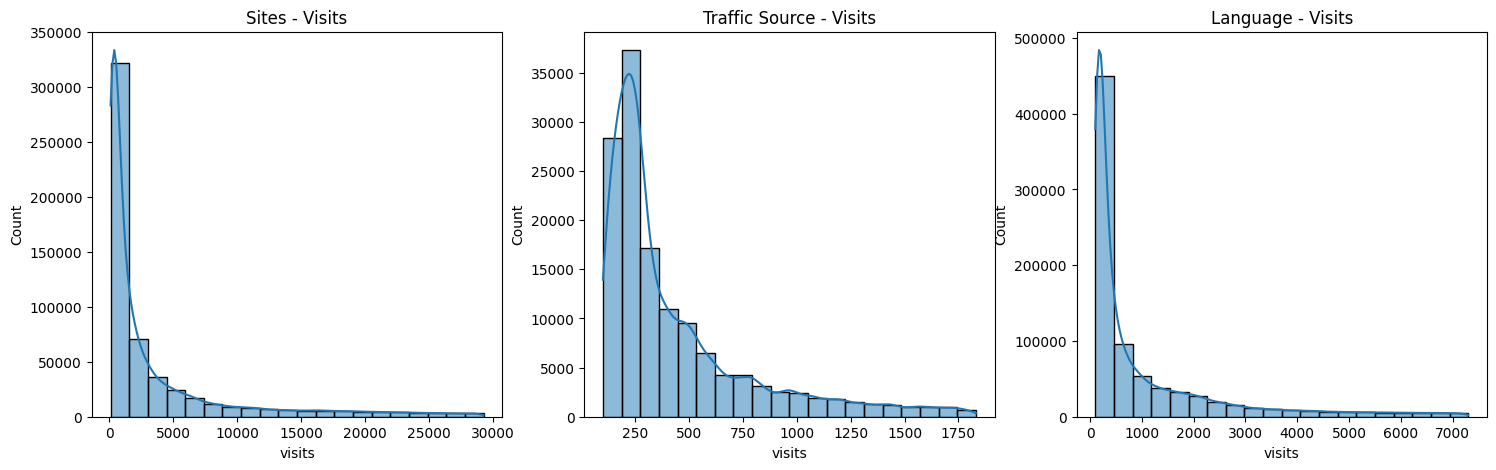

In [33]:
# Create a figure with a subplot for each agency.
plt.figure(figsize=(18, 5))

# Create a histogram for each report.
plt.subplot(1, 3, 1)
sns.histplot(data=sites_no_outliers, bins=20, kde=True)
plt.title('Sites - Visits')

plt.subplot(1, 3, 2)
sns.histplot(data=traffic_source_no_outliers, bins=20, kde=True)
plt.title('Traffic Source - Visits')

plt.subplot(1, 3, 3)
sns.histplot(data=language_no_outliers, bins=20, kde=True)
plt.title('Language - Visits')

# Show the plot
plt.show()

### Visualizing and Analyzing Results

- [Alex] What domains were the most visited (top 10) for each agency for the period of Q1’20 and Q2’20 (just when COVID started)
    - Any interesting observations?
    - No plot
- [Alex] For a given year (for instance, 2022 or 2020) can we spot any seasonal patterns in # visits across each of the main agencies
    - Graph: plot # daily visits per agency for a given year
    - Potentially zoom in a specific agency and plot 5 top domains
- [Austin] What are the most common sources of traffic to sites of each of the different agencies? What are the sources that grew the most y/y in 2022 (vs 2021)
    - Plot: cumulative visits per source (filter by top 5 sources) during 2022 for each agency
- [Austin] How many languages do sites from different agencies support? Are there any notable differences between language distribution across the 4 agencies selected? (for example: social-security might be x% ES language whereas 'postal-service' might be y%)
    - If possible, combine all english languages into one bucket, and same for other languages
    - 412 unique languages
    - Plot: stacked bar chart showing % distribution of top languages by agency

- [Alex] What domains were the most visited (top 10) for each agency for the period of Q1’20 and Q2’20 (just when COVID started)
    - Any interesting observations?
    - No plot

- [Alex] For a given year (for instance, 2022 or 2020) can we spot any seasonal patterns in # visits across each of the main agencies
    - Graph: plot # daily visits per agency for a given year
    - Potentially zoom in a specific agency and plot 5 top domains

- [Austin] What are the most common sources of traffic to sites of each of the different agencies? What are the sources that grew the most y/y in 2022 (vs 2021)
    - Plot: cumulative visits per source (filter by top 5 sources) during 2022 for each agency

- [Austin] How many languages do sites from different agencies support? Are there any notable differences between language distribution across the 4 agencies selected? (for example: social-security might be x% ES language whereas 'postal-service' might be y%)
    - If possible, combine all english languages into one bucket, and same for other languages
    - 412 unique languages
    - Plot: stacked bar chart showing % distribution of top languages by agency

In [ ]:
df_sites.groupby('report_agency')['visits'].sum().sort_values(ascending=False)

report_agency
postal-service                    52698630621
treasury                          20893372058
health-human-services             19199126546
social-security-administration     3595729500
Name: visits, dtype: int64

In [ ]:
df_traffic_source.groupby('source')['visits'].sum().sort_values(ascending=False).head(20)

source
google                       1007093944
(direct)                      479199136
irs.gov                       116813670
reg.usps.com                  112277781
usps.com                       82852147
bing                           60007849
sa.www4.irs.gov                41929448
informeddelivery.usps.com      40009972
ssa.gov                        34608887
secure.ssa.gov                 29732427
pubmed.ncbi.nlm.nih.gov        28516330
tools.usps.com                 19866019
govdelivery                    16958616
yahoo                          15847819
secure.login.gov               13464243
m.facebook.com                 11701368
expected                       10802440
ncbi.nlm.nih.gov               10720673
search.ssa.gov                 10379316
faq.ssa.gov                     8977171
Name: visits, dtype: int64

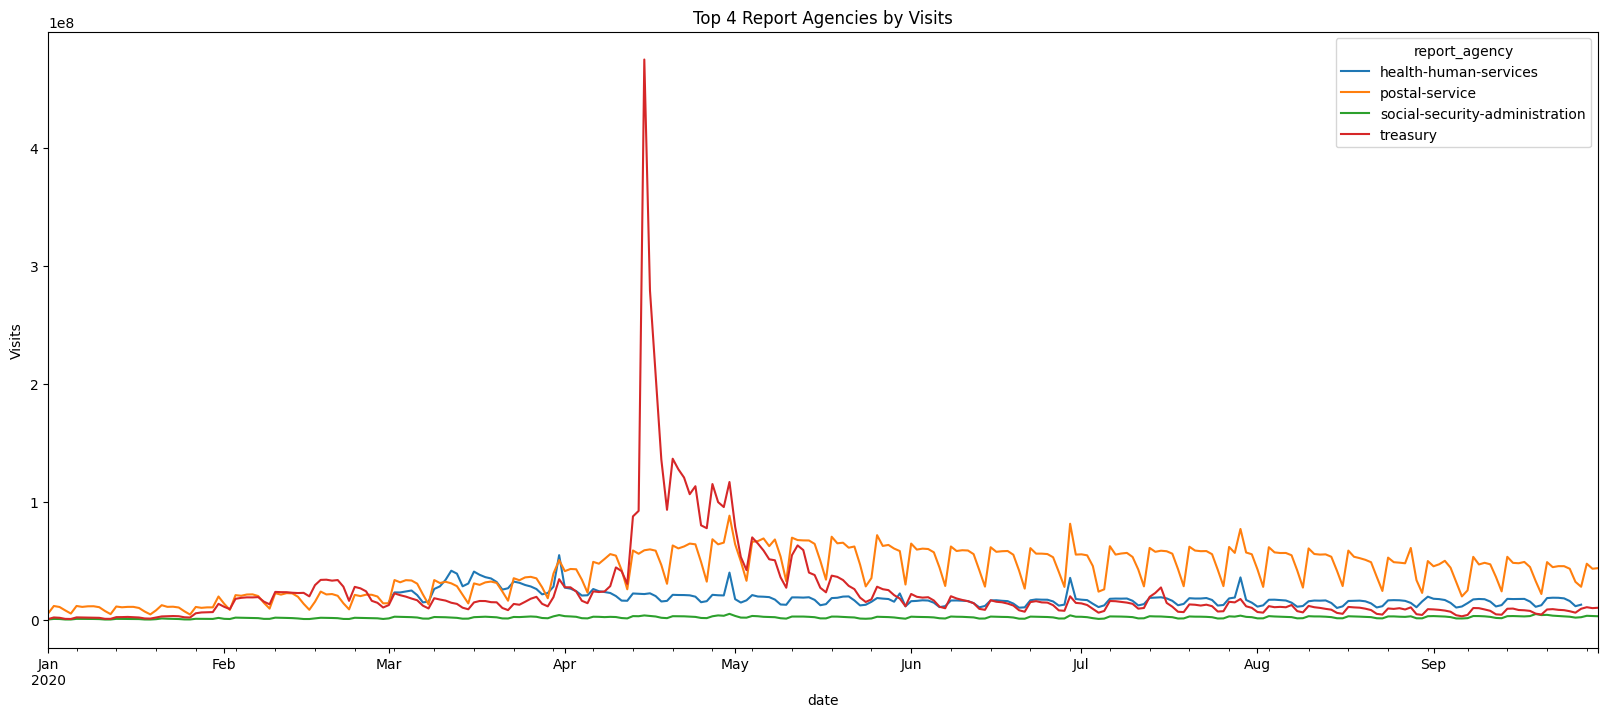

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

df_grouped = df_sites.groupby(['date', 'report_agency']).agg({'visits': 'sum'})
top_agencies = df_grouped.groupby('report_agency').agg({'visits': 'sum'}).nlargest(5, 'visits').index

df_filtered = df_grouped[df_grouped.index.get_level_values('report_agency').isin(top_agencies)]
df_pivot = df_filtered.pivot_table(index='date', columns='report_agency', values='visits')

df_pivot = df_pivot.loc['2020-01': '2020-09']

df_pivot.plot.line(ax=ax)

plt.ylabel('Visits')
plt.title('Top 4 Report Agencies by Visits')
plt.show()

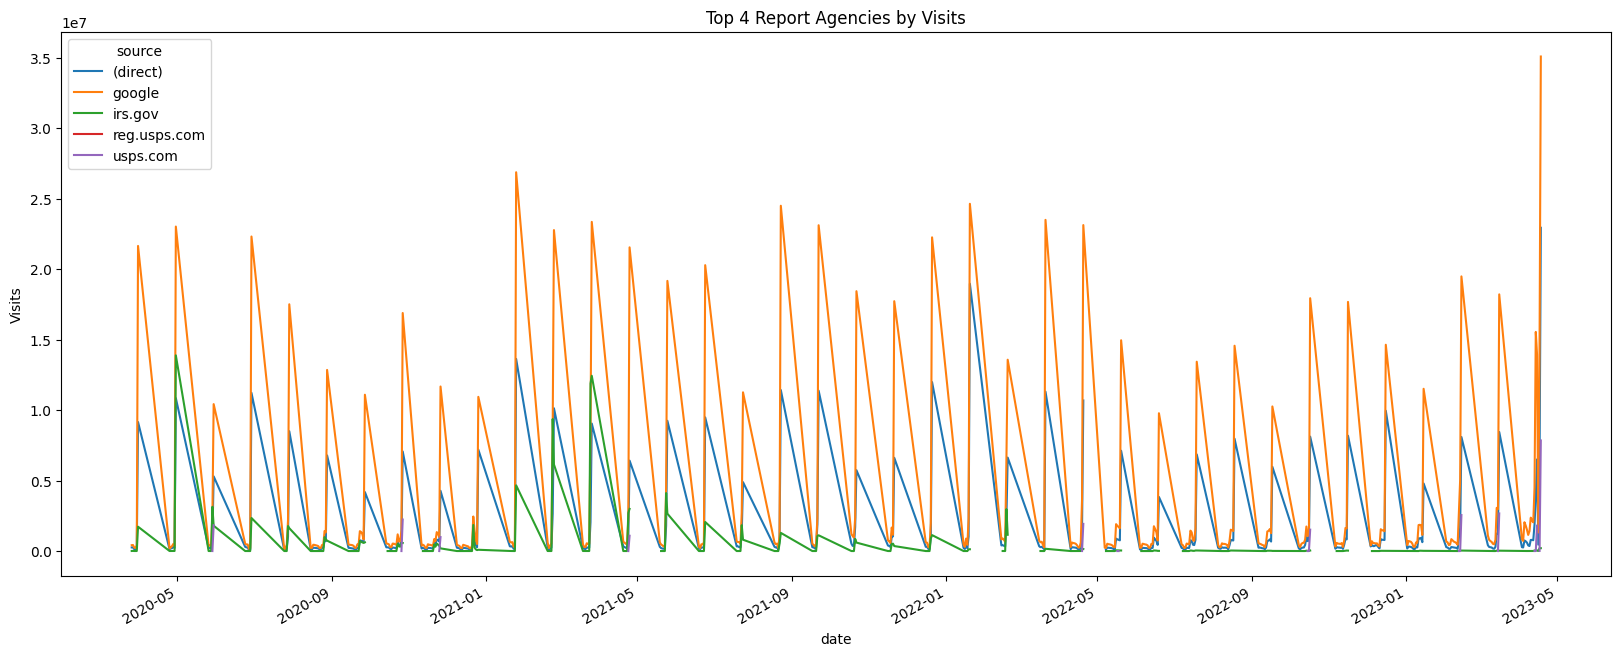

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))

df_grouped = df_traffic_source.groupby(['date', 'source']).agg({'visits': 'sum'})
top_agencies = df_grouped.groupby('source').agg({'visits': 'sum'}).nlargest(5, 'visits').index

df_filtered = df_grouped[df_grouped.index.get_level_values('source').isin(top_agencies)]
df_pivot = df_filtered.pivot_table(index='date', columns='source', values='visits')

df_pivot.plot.line(ax=ax)

plt.ylabel('Visits')
plt.title('Top 4 Report Agencies by Visits')
plt.show()

In [ ]:
print("Min date:", pivot_table.index.min())
print("Max date:", pivot_table.index.max())

Min date: 2020-01-01 00:00:00
Max date: 2023-04-17 00:00:00


OverflowError: int too big to convert

Error in callback <function _draw_all_if_interactive at 0x7f2cba9f7d90> (for post_execute):


OverflowError: int too big to convert

OverflowError: int too big to convert

<Figure size 1500x1000 with 1 Axes>